### We need the following packages :
 - CSV",
 - "Revise"
 - "Plots"
 - "QuantEcon"
 - "Parameters"
 - "SymEngine" 
 - "Random",
 - "LinearAlgebra",
 - "StatsBase" 
 - "BasisMatrices" 
 - "ForwardDiff" 
 - "DataFrames"
 
 import Pkg
Pkgs = ["CSV","Revise","Plots","QuantEcon","Parameters",
        "SymEngine","Random","LinearAlgebra","StatsBase","BasisMatrices","ForwardDiff","DataFrames"]

 for pkg in Pkgs 
    println("Checking for $pkg")
    Pkg.add(pkg)
 end

In [1]:
using CSV
using Dates
using Revise 
using Plots 
using QuantEcon
using Parameters
using SymEngine
using Random
using LinearAlgebra
using StatsBase
using BasisMatrices
using ForwardDiff
using DataFrames

## Q2 - Quadratic Trend Decomposition of Time Series

Let $y_t$ be the log of some time series (real output per capita, for example). Then this can be decomposed into a trend component $y^\tau_t$ and a cyclical component $y^c_t$:

$$
y_t = y^\tau_t + y^c_t \tag{1}
$$

If we assume that the series follows a quadratic trend, then:

$$
y_t = a + b t + c t^2 + \epsilon_t \tag{2}
$$
$$
y^\tau_t = a + b t + c t^2 \tag{3}
$$
$$
y^c_t = \epsilon_t \tag{4}
$$

### 1: Load and View the Data

We will read the `data.csv` file into a DataFrame. This file contains the log of output, the log of consumption, and the log of investment for the US from roughly 1980Q1 to 2020Q4.

In [2]:
data = DataFrame(CSV.File("data.csv")) ;

### 2: What is the length of the array that stores log of output? 
Use size(df,1) to find out. Store this variable as T.

In [3]:
T=size(data,1);
println("Number of Time periods:  $T")

Number of Time periods:  160


In [4]:
start_date = Date("1980-01-01")  # Start from 1980Q1 - generating dates
quarters = [start_date + Month(3) * i for i in 0:T-1];  # Generate 160 quarterly dates , list comprehension works !
# Add the date column to the DataFrame
data.date = quarters ;  # add semicolon - works like matlab 

In [5]:
#first(data, 5)
# last(data, 5)

### 3: Create a dummy year variable that ranges from 1 to T. 
You should have an array going from 1, 2, 3, ..., T. Call that variable something like year. Create another array, call it yearsq, that squares each element of year so that it’s 1, 4, 9, ..., T2.

In [6]:
function quad_data(series)
    y=series
    T=length(series)
    year=1:T
    yearsq =year.^2
    x = hcat(ones(T),year,yearsq)
    return y,x
end

quad_data (generic function with 1 method)

### 4: Now only take the output column, which you can extract it by df[:,:y], and decompose the log of output
 - into a trend and a cyclical component using a quadratic filter.
   -  To do this, first, create a function called ols(Y, X) that takes any column vector Y
      and a generic (n by k) matrix X and returns  $\hat{\beta}$, try to see if you can also return the
      variance-covariance matrix V.
 - Regress log of output Y on a vector of constant, year, and yearsq. 
 - Generate predicted values, which correspond to the trend component. The difference between the
   predicted value, $\hat{Y}$ , and $Y$ is the cyclical component.
- Using a Plots package, plot the log of output and the trend component in one figure.
Make sure to label the lines. Create a separate plot that plots the cyclical component.
Can you combine the two figures so that there are two subplots?

In [7]:
function OLS(Y, X)
    """
    Perform Ordinary Least Squares (OLS) regression.
    
    Inputs:
    Y - dependent variable (response), X - independent variables (design matrix).
    
    Returns:
    beta_hat - estimated coefficients
    Y_hat    - predictions
    e_hat - residuals (Y - Y_hat)
    var_cov_matrix - variance-covariance matrix (non-robust)
    """
    n = length(Y)  # Number of observations
    k = size(X, 2)  # Number of independent variables (including intercept)
    XT = transpose(X)
    
    beta_hat = (XT * X) \ (XT * Y)  # OLS coefficients : backslash works like matlab
    
    # Step 3: Fitted values and residuals
    Y_hat = X * beta_hat  # Predicted values (fitted values)
    e_hat = Y - Y_hat     # Residuals (errors)
    
    # Step 4: Compute the non-robust variance-covariance matrix of beta_hat
    sigma_squared = (transpose(e_hat) * e_hat) / (n - k)  # Residual variance (sigma^2)
    
    # var_cov_matrix = sigma_squared[1] * ((XT * X) \ I)    # Variance-covariance matrix
    var_cov_matrix = sigma_squared[1] * (inv(XT * X))
    # Return the OLS estimates, fitted values, residuals, and variance-covariance matrix
    return beta_hat, Y_hat, e_hat, var_cov_matrix , n,k
end


OLS (generic function with 1 method)

In [8]:
Y = data[:,:Y];

In [9]:
# call quad_data 
y, x = quad_data(Y);
# call OLS
beta_hat, Y_hat, e_hat, var_cov_matrix,n,k=OLS(y, x);

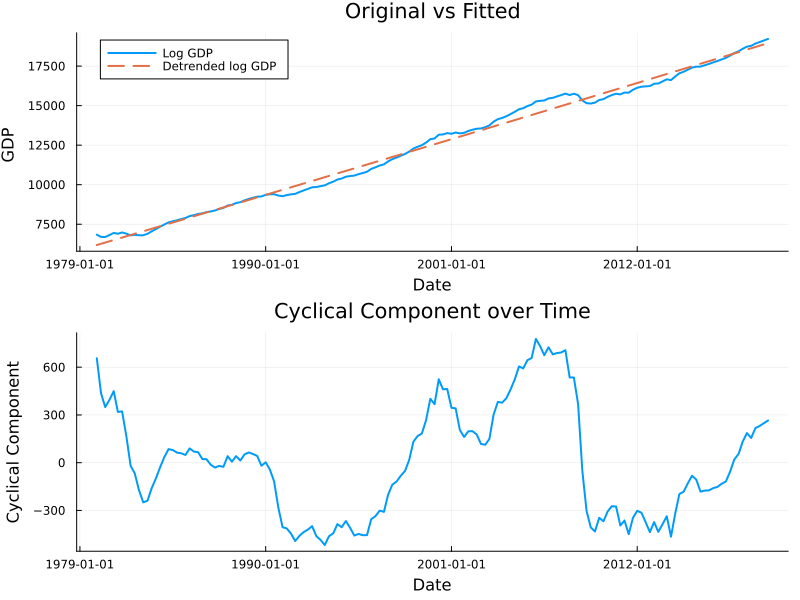

In [10]:
p1 = plot(data.date, Y, label="Log GDP", lw=2, xlabel="Date", ylabel="GDP ", title="Original vs Fitted")
plot!(data.date, Y_hat, label="Detrended log GDP ", lw=2, linestyle=:dash)
p2 = plot(data.date, e_hat, label="", lw=2, xlabel="Date", ylabel="Cyclical Component", title="Cyclical Component over Time")
plot(p1, p2, layout=(2, 1), size=(800, 600))

### 5. Now, repeat the previous steps to decompose consumption and investment as well. 
- ImportStatsBase package by Using StatsBase. Using only the cyclical components, calculate
    - standard deviations, first-order autocorrelations, and correlations with output for y, c, i in
   Julia. No need to put it in a fancy table, just make sure to display answers using println.

In [11]:
# Initialize a dictionary to store results for each variable
results_dict = Dict()

# Loop through two lists simultaneously using `zip` - works like python 
for (i, j) in zip([1,2,3], ["Y","C","I"])
    
    Y = data[!,i]
    
    # Call quad_data to generate y and x
    y, x = quad_data(Y)
    
    # Call OLS on y and x
    beta_hat, Y_hat, e_hat, var_cov_matrix,n,k = OLS(y, x)
    
    # Store the results in a dictionary with `j` as the key : is a symbol - can omit as well 
    results_dict[j] = Dict(
        :Original => Y,
        :Beta_hat => beta_hat,
        :Predicted => Y_hat,
        :Residuals => e_hat,
        :Var_Cov_Matrix => var_cov_matrix
    )
    
    # Optionally print results for each loop iteration
    println("Results for $j stored in results_dict")
end



Results for Y stored in results_dict
Results for C stored in results_dict
Results for I stored in results_dict


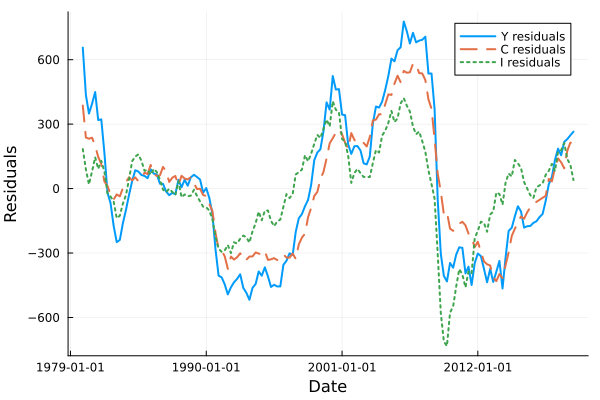

In [12]:
plot(data.date, results_dict["Y"][:Residuals], label="Y residuals", lw=2, xlabel="Date", ylabel="Residuals")

plot!(data.date, results_dict["C"][:Residuals], label="C residuals", lw=2, linestyle=:dash)

plot!(data.date, results_dict["I"][:Residuals], label="I residuals", lw=2, linestyle=:dot)



In [13]:
y_cyclical = results_dict["Y"][:Residuals]  # Cyclical component of y
c_cyclical = results_dict["C"][:Residuals]  # Cyclical component of c
i_cyclical = results_dict["I"][:Residuals]  # Cyclical component of i

# 1: standard deviations
std_y = std(y_cyclical)
std_c = std(c_cyclical)
std_i = std(i_cyclical)

# 2: First-order autocorrelations
autocorr_y = autocor(y_cyclical,[1])
autocorr_c = autocor(c_cyclical,[1])
autocorr_i = autocor(i_cyclical,[1])

# Step 3: Calculate correlations with output (y)
corr_y_y = cor(y_cyclical, y_cyclical)  
corr_c_y = cor(c_cyclical, y_cyclical)
corr_i_y = cor(i_cyclical, y_cyclical)

# Step 4: Display the results
println("Standard Deviations:")
println("y: ", std_y)
println("c: ", std_c)
println("i: ", std_i)

println("\nFirst-Order Autocorrelations:")
println("y: ", autocorr_y)
println("c: ", autocorr_c)
println("i: ", autocorr_i)

println("\nCorrelations with Output (y):")
println("y vs y: ", corr_y_y)
println("c vs y: ", corr_c_y)
println("i vs y: ", corr_i_y)


Standard Deviations:
y: 343.92985016901935
c: 260.26649780755474
i: 218.08544586831596

First-Order Autocorrelations:
y: [0.9612915078824801]
c: [0.9776510885048716]
i: [0.9598955054188429]

Correlations with Output (y):
y vs y: 1.0
c vs y: 0.9558942764378113
i vs y: 0.7991410127628611


## Question 3: AR(1) Process

Let $ y_t $ be income for an individual. One simple way to model an income process is through an autoregressive model of order 1. This can be written as:

$$
y_t = (1 - \rho)\mu + \rho y_{t-1} + \epsilon_t
$$

where $ \epsilon_t \sim N(0, \sigma^2) $, with:
- $ \rho $ being a parameter that controls persistence,
- $ \mu $ being the mean, and
- $ \sigma^2 $ being the variance of the innovation term.

### 1. What is the mean and the variance for $ y_t$? 

Ans:

$$
\begin{align}
y_t &= (1 - \rho)\mu + \rho y_{t-1} + \epsilon_t \\
y_t &= (1 - \rho)\mu + \rho \left( (1 - \rho)\mu + \rho y_{t-2} +  \epsilon_{t-1} \right) + \epsilon_t \\
    & \vdots \\
y_t &= (1 - \rho)\mu \sum_{k=0}^{\infty} \rho^k + \sum_{k=0}^{\infty} \rho^k \epsilon_{t-k} \\
\implies E(y_t) &= (1 - \rho)\mu \frac{1}{(1 - \rho)} + \sum_{k=0}^{\infty} \rho^k E(\epsilon_{t-k}) = \mu \\
\implies V(y_t) =  \sum_{k=0}^{\infty} \rho^{2k}\sigma^2  = \frac{\sigma^2}{1-\rho^{2}}
\end{align}
$$


### 2. White noise process Set $\sigma^2$ = 0.01. 
Using a randn command, draw ϵt for 100 periods and plot them. Notice that randn draws from standard normals. How could you manipulate the simulated series so that the resulting series has a variance of 0.01?


In [14]:
# Set the seed for reproducibility, weird usage in Julia  
function rr()
    rng = MersenneTwister(2);
    return rng
end

rr (generic function with 1 method)

### 
$$
\begin{align}
X = \mu+\sigma Z\\
X \sim N(\mu,\sigma^2) , Z \sim N(0,1)
\end{align}
$$
is the required transformation 

In [15]:
T_sim = 100;
sigma = sqrt(0.01);  # Standard deviation of the innovation term

# Simulate the innovation term (white noise)
e_sim = sigma * randn(rr(),T_sim);  # X = sigma*Z is the required transformation 

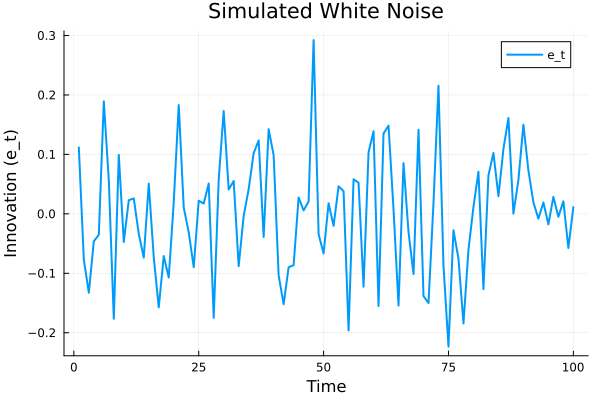

In [16]:
# Plot the simulated white noise
plot(1:T_sim, e_sim, label="e_t", lw=2, xlabel="Time", ylabel="Innovation (e_t)", title="Simulated White Noise")

## 3. Simulation Set 
- μ = 0.6, ρ = 0.6, y0 = μ. Using a similar procedure as above, simulate the above process for T = 10, 100, 1000. Calculate what the mean and the variance of y are for each of the cases. 
- What happens as you increase T?

Ans . The mean is .6 and variance  is $.01/(1-.6^2)= 0.015625 $

In [17]:
mu = .6
rho = .6
y0 = mu
results_sim_dict = Dict()
for t in [10,100,1000]
    e_sim = sigma * randn(rr(),t)
    y_sim = zeros(t)
    y_sim[1] = y0
    for i=2:t
        y_sim[i]=(1-rho)*mu+rho*y_sim[i-1]+e_sim[i]
    end
    # Store the simulated y_t for this time period in the dictionary
    results_sim_dict[t] = y_sim
    # Calculate the mean and standard error (standard deviation / sqrt(n))
    mean_y = mean(y_sim)
    variance_y = var(y_sim)  # By default, uses n-1
    # Print the mean and standard error
    println("Results for t = $t:")
    println("Mean: $mean_y")
    println("Variance : $variance_y")
    println()
end

Results for t = 10:
Mean: 0.561106977723204
Variance : 0.011467929179429653

Results for t = 100:
Mean: 0.6034948864334768
Variance : 0.01568402284509024

Results for t = 1000:
Mean: 0.6102881221054147
Variance : 0.015055601220404563



### Thus as T increases  the estimates becomes precise

### 4. Using a simulated dataset from the previous problem for T = 1000, get the estimated $\rho$ and $\mu$

### Ans : Can use OLS to estimate $\rho$ and $\mu$ : Reg $y_t$ on $y_{t-1}$

In [18]:
T=1000;
y_sim = results_sim_dict[T];
Y = y_sim[2:T];
y_ar_lag1 = y_sim[1:T-1];
X = hcat(ones(T-1),y_ar_lag1) ;
beta_hat, Y_hat, _, _ ,_,_= OLS(Y,X);

In [19]:
# beta_hat[2] is the AR(1) coefficient (ρ)
rho_estimate = beta_hat[2] ;
mu_estimate  = mean(Y_hat) ;

In [20]:
println("Estimate of rho is $rho_estimate") 
println("Estimate of mu is $mu_estimate") 

Estimate of rho is 0.5664479742363127
Estimate of mu is 0.6102984205259401


### 5. Impulse Response Function Suppose we are at $y_0 = \mu = 0$ and we receive a stimulus check of $\sigma$.
We do not foresee another stimulus check in the near future. Plot the path of $y_t$ for the
next 48 periods when $\rho$ = 0.6. In that same graph, plot what the path will be when $\rho$ = 0.4
and $\rho$ = 0.99. Make sure to label each line.

### Ans: 

$$
\begin{align}
y_t &= \rho y_{t-1} + \epsilon_t \\
\text{Now,} & \ y_0 = 0, \ \epsilon_1 = \sigma, \ \text{and} \ \epsilon_t = 0 \ \forall \ t > 1 \\
y_1 &= \rho y_0 + \epsilon_1 \\
y_1 &= \sigma \\
y_2 &= \rho \sigma \\
y_3 &= \rho^2 \sigma \\
& \ \vdots \\
\implies y_t &= \rho^{t-1} \sigma \ \text{for} \ t \geq 1
\end{align}
$$


In [21]:
# Define parameters
y0 = 0
rho_vals = [0.4, 0.6, .99]
sigma = 0.1  # 10% shock
T = 48       # Time periods
y_dict = Dict()  # Dictionary to store the results for each rho

# Loop over each value of rho
for r in rho_vals
    y = zeros(T)  # Initialize the array to store y_t
    y[1] = sigma  # Initial shock at t=1
    
    # Simulate for each time period t ≥ 2
    for t in 2:T
        y[t] = r^(t-1) * sigma  # Using the impulse response function
    end
    
    # Store the result for the current rho in the dictionary
    y_dict[r] = y
end


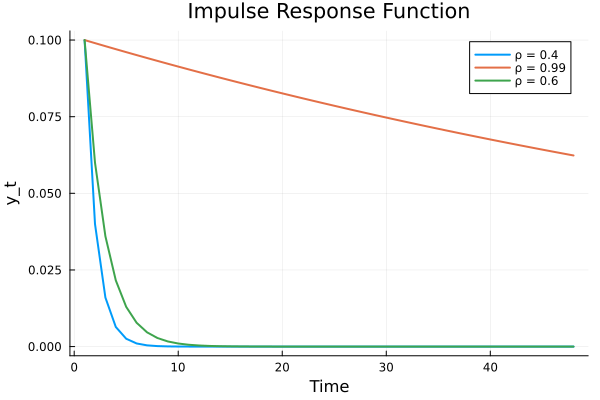

In [22]:
# Plotting
p = plot(title="Impulse Response Function", xlabel="Time", ylabel="y_t", lw=2)

# Add a line for each value of rho
for (r, y_vals) in y_dict
    plot!(p, 1:T, y_vals, label="ρ = $r", lw=2)  # Add each rho's line to the plot
end

# Show the plot
display(p)

### For high persistence - a one time shock has permanent effects